# Wstęp 
W notantiku przedstawiono analizę danych dla zbioru planes_assign. Zbiór zawierał dziewięć klas zdjęć. Przedstawiały one samoloty w różnych ujęciach lub inne obiekty (helikoptery itd). Klasy występujące w analizie to:
'helicopter', 'not_assigned', 'not_plane', 'plane_common', 'plane_large', 'plane_partial', 'plane_too_far', 'plane_with_trail', 'something_strange'. 


Celem analizy było utworzenie modeli pozwalających na rozróżnianie tych klas. Pierwszym etapem analizy było wczytanie i przygotowanie danych, a następnie utworzenie i porównanie kilku modeli. Skupiono się na sieciach konwolucyjnych CNN i podejściach z balansem i bez balansu klasowego (modyfikajce wag dla klas). Przedstawiono również maodel wykorzystujący losowe modyfikacje obrazów celem poprawy jakości klasyfikacji. Wyniki zestawiono z wykorzystaniem macierzy pomyłek oraz raportu klasyfikacji.

# Pakiety i wczytanie danych 
Pierwszym krokiem w analizie będzie wczytanie odpowiednich pakietów.

In [3]:
# Import pakietów 
import os
import numpy as np
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore') 

In [6]:
#Ścieżka do katyalogu głównego z obrazami
data_dir = "./planes_assign"

In [7]:
# Tworzymy funkcję, która pozwoli nam na wczytanie każdego obrazu wraz z jego etykietą

In [8]:
def load_images_and_labels(data_dir):
    """
    Funkcja wczytująca obrazy i ich etykiety do list
    """
    images = []
    labels = []

    # Przechodzenie przez każdy podkatalog w katalogu głównym
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            # Przechodzenie przez każdy plik w podkatalogu
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                # Wczytanie obrazu
                image = Image.open(file_path)
                # Normalizacja do zakresu 0-1
                image = np.array(image) / 255.0 
                images.append(image)
                # Przypisywanie etykiety na podstawie nazwy pliku
                label = file_path.split('.')[-3]
                labels.append(label)
    
    return np.array(images), np.array(labels)

In [9]:
# Wczytywanie obrazów i etykiet 
images, labels = load_images_and_labels(data_dir)

In [10]:
# Ile mamy wystapień każdej z klas?
print(np.unique(labels, return_counts=True))

(array(['helicopter', 'not_assigned', 'not_plane', 'plane_common',
       'plane_large', 'plane_partial', 'plane_too_far',
       'plane_with_trail', 'something_strange'], dtype='<U17'), array([  166,  1683,  5970,  1780,   178,    42,  3787, 16133,   328]))


Można zauważyć, że zbiór danych jest bardzo niezbalansowany. Mamy bardzo dużo obrazów z klas plane_partial oraz plane_large 
 i not_plane, a bardzo mało pozostałych.

In [ ]:
# Zmiana etykiet na wartości numeryczne

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [12]:
labels = le.fit_transform(labels)

In [13]:
labels

array([6, 3, 7, ..., 7, 3, 2])

In [14]:
#Ile mamy wystąpień każdej klasy 
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([  166,  1683,  5970,  1780,   178,    42,  3787, 16133,   328]))


In [15]:
# Prezentacja odwrotnej transformacji

In [16]:
le.inverse_transform([[1]])

array(['not_assigned'], dtype='<U17')

# Podział danych 
W tym kroku podzielono dane na treningowe, walidacyjne i testowe. Umożliwi to trening i walidację tworzonych modeli.

In [ ]:
# Podział danych na traningowe, walidacyjne i testowe

In [17]:
from sklearn.model_selection import train_test_split

# Najpierw dzielimy dane na część treningową i pozostałą
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.30, random_state=42
)

# Następnie dzielimy pozostałą część na zbiory walidacyjny i testowy
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.50, random_state=42
)

In [18]:
# Zerknijmy na liczbę obrazów w każdej z klas.

In [19]:
print(f"Liczba obrazów treningowych: {len(train_images)}")
print(f"Liczba obrazów walidacyjnych: {len(val_images)}")
print(f"Liczba obrazów testowych: {len(test_images)}")

Liczba obrazów treningowych: 21046
Liczba obrazów walidacyjnych: 4510
Liczba obrazów testowych: 4511


# Modelowanie 
W tej częsci notatnika zaprezentowano modelowanie. Utworzono kilka modeli konwolucyjnych sieci neuronowych (CNN) i przeprowadzono ich trening. W tym celu wykorzystano pakiet tensorflow.

# Model 1 
##  Bez balansu klasowego 
Tworzony model jest sekwencyjnym modelem konwolucyjnym przeznaczonym do analizy obrazów. Składa się z dwóch warstw konwolucyjnych, dwóch warstw poolingowych, oraz warstw gęstych. . Na jego wyjściu otrzymujemy dziewięć wartości reprezentujących prawdopodobieństwo przynależności do jednej z dziewięciu klas. 

In [20]:
from keras.api.models import Sequential 
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Budowanie modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
]);

In [21]:
# Kompilacja modelu - model będzie uczył się minimalizować stratę binarnej klasyfikacji i monitorował dokładność 
# klasyfikacji podczas treningu
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Wyświetlenie podsumowania modelu
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,249 (8.34 MB)

 Trainable params: 2,186,249 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Uruchamiamy trening modelu 

In [24]:
history_unbalanced = model.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels));

Epoch 1/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5475 - loss: 1.3600 - val_accuracy: 0.6330 - val_loss: 1.1645
Epoch 2/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6300 - loss: 1.1084 - val_accuracy: 0.6940 - val_loss: 1.0078
Epoch 3/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6731 - loss: 0.9842 - val_accuracy: 0.6991 - val_loss: 0.8672
Epoch 4/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7095 - loss: 0.8651 - val_accuracy: 0.7273 - val_loss: 0.7822
Epoch 5/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7366 - loss: 0.7868 - val_accuracy: 0.7716 - val_loss: 0.7190
Epoch 6/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7620 - loss: 0.7314 - val_accuracy: 0.7747 - val_loss: 0.6975
Epoch 7/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.7722 - loss: 0.7016 - val_accuracy: 0.7814 - val_loss: 0.6784
Epoch 8/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7768 - loss: 0.6728 - 

# Model 2 
Z balansem klasowym(wagi)

In [25]:
# Budowanie modelu (ta sama architektura celem porównania podejśćia)
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])

# Kompilacja modelu
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
from sklearn.utils.class_weight import compute_class_weight

# Obliczanie wag dla klas
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {i : class_weights[i]
                     for i in range(9)}

In [27]:
class_weight_dict

{0: 21.854620976116305,
 1: 1.9601378411101797,
 2: 0.5559782321551223,
 3: 1.85149995601302,
 4: 19.650793650793652,
 5: 73.07638888888889,
 6: 0.8824318658280922,
 7: 0.20784325343920046,
 8: 10.393086419753086}

In [28]:
class_weight_dict_names = {le.inverse_transform(np.array([i]))[0] : class_weights[i] for i in range(9)}

In [29]:
class_weight_dict_names

{'helicopter': 21.854620976116305,
 'not_assigned': 1.9601378411101797,
 'not_plane': 0.5559782321551223,
 'plane_common': 1.85149995601302,
 'plane_large': 19.650793650793652,
 'plane_partial': 73.07638888888889,
 'plane_too_far': 0.8824318658280922,
 'plane_with_trail': 0.20784325343920046,
 'something_strange': 10.393086419753086}

In [30]:
# Można zauwaćyć, że klasa plane_partial otrzymała najwyższą wagę z powodu małej liczności. 
# Podejście powyżej nie przyniosło efektów - accuracy bliskie 0. A więc wagi możemy ustawić też ręcznie, wiedząc że liczba
# wystąpień poszczególnych klas to:
#'helicopter' : 166
#'not_assigned' : 1683
#'not_plane': 5970
#'plane_common': 1780
#'plane_large': 178
#'plane_partial': 42
#'plane_too_far': 3787
#'plane_with_trail': 16133
#'something_strange']: 328

In [33]:
class_weight_dict = {
 0: 5,
 1: 4,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 5,
 7: 1,
 8: 5}

In [34]:
# Trenowanie modelu z ważeniem klas
history_balanced = model2.fit(train_images, train_labels, epochs=30, validation_data=(val_images, val_labels), class_weight=class_weight_dict)

Epoch 1/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.2120 - loss: 4.0831 - val_accuracy: 0.2741 - val_loss: 1.4849
Epoch 2/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4591 - loss: 3.6675 - val_accuracy: 0.5776 - val_loss: 1.1774
Epoch 3/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5897 - loss: 3.1962 - val_accuracy: 0.6583 - val_loss: 1.0136
Epoch 4/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6770 - loss: 2.7641 - val_accuracy: 0.7326 - val_loss: 0.8323
Epoch 5/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7005 - loss: 2.6113 - val_accuracy: 0.7007 - val_loss: 0.8996
Epoch 6/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7114 - loss: 2.5583 - val_accuracy: 0.7237 - val_loss: 0.8049
Epoch 7/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7375 - loss: 2.3836 - val_accuracy: 0.7135 - val_loss: 0.8630
Epoch 8/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7376 - loss: 2.3410 - 

 # Predykcje i porówanie Modelu 1 i 2

W tej części dokonano porównania modelu z balansem klasowym i bez niego.

In [35]:
# Ewaluacja dokładności na zbiorze testowym - nie biorącym udziału w nauce
accuracy_unbalanced = model.evaluate(test_images, test_labels)[1]
accuracy_balanced = model2.evaluate(test_images, test_labels)[1]

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8042 - loss: 0.6036
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7894 - loss: 0.6969


In [36]:
print("Dokładność modelu bez balansu klas: {:.2f}%".format(accuracy_unbalanced * 100))
print("Dokładność modelu z balansem klas: {:.2f}%".format(accuracy_balanced * 100))

Dokładność modelu bez balansu klas: 80.23%
Dokładność modelu z balansem klas: 79.38%


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predykcje modeli
pred_labels_unbalanced = np.argmax(model.predict(test_images), axis=-1)
pred_labels_balanced = np.argmax(model2.predict(test_images), axis=-1)

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [38]:
# Macierz pomyłek dla obu modeli
cm_unbalanced = confusion_matrix(test_labels, pred_labels_unbalanced)
cm_balanced = confusion_matrix(test_labels, pred_labels_balanced)

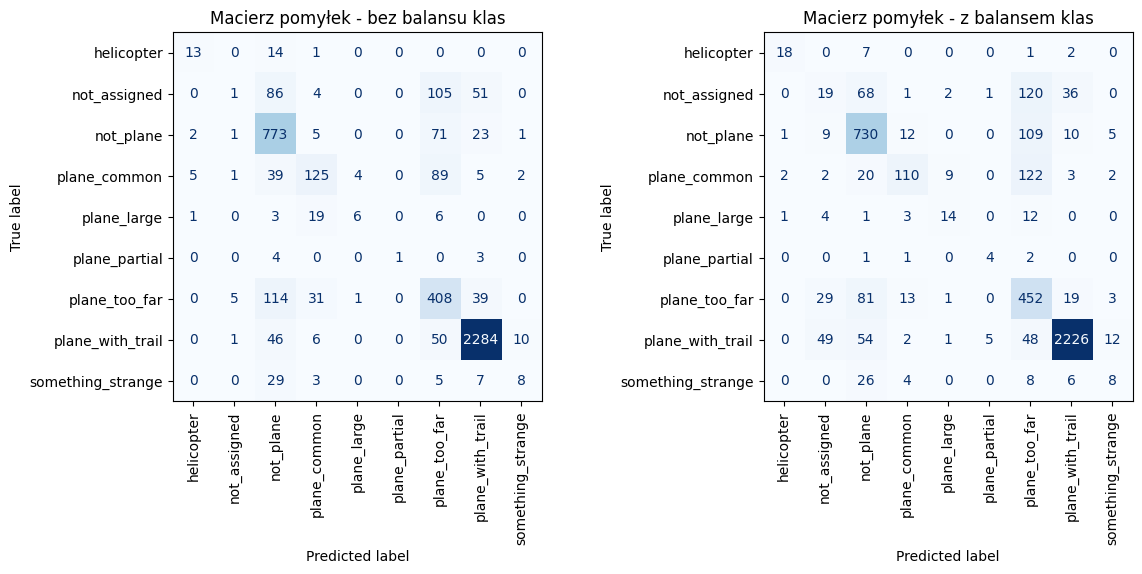

In [39]:
# Wyświetlanie macierzy pomyłek
labels_inv = [le.inverse_transform([i])[0] for i in range(9)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Ustawienia odstępów dla pierwszego subplotu
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
ConfusionMatrixDisplay(cm_unbalanced, display_labels=labels_inv).plot(ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Macierz pomyłek - bez balansu klas')
ax[0].tick_params(axis='x', rotation=90) 

# Ustawienia odstępów dla drugiego subplotu
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.6, hspace=0.5)
ConfusionMatrixDisplay(cm_balanced, display_labels=labels_inv).plot(ax=ax[1], cmap='Blues', colorbar=False)
ax[1].set_title('Macierz pomyłek - z balansem klas')
ax[1].tick_params(axis='x', rotation=90) 

plt.show()

Obserwacje: 

Balans klasowy nie przyniósł tutaj znaczącej korzyści. Lepiej poszło modelowi bez balansu klasowego (skuteczność 80%). Można zauważyć, że model myli się między samolotami w oddali oraz "nie-samolotami". W każdym razie, dokładnośc modelu jest bardzo dobra i wynosi prawie 79% na danych testowych.

In [41]:
# Funkcja do wyświetlania krzywych uczenia
def plot_learning_curves(history, title='Learning Curves'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

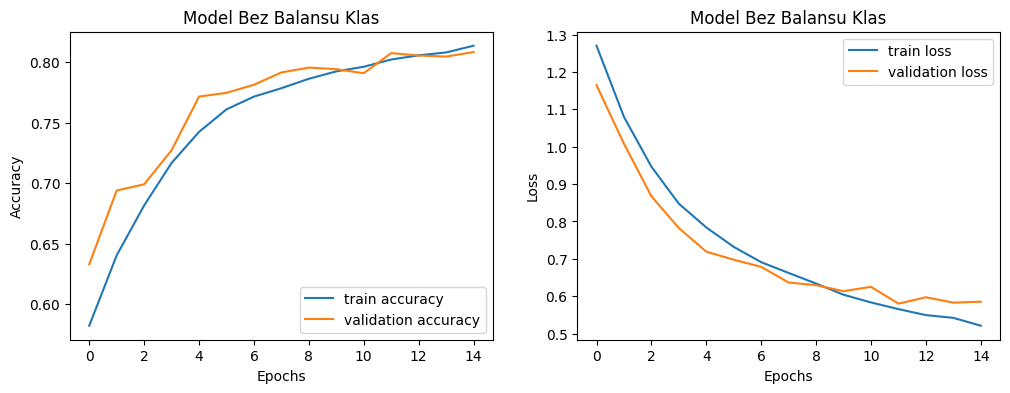

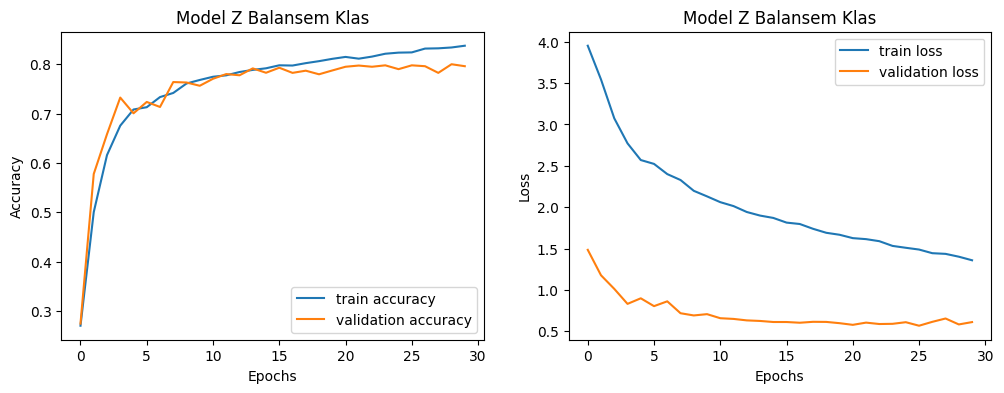

In [42]:
# Wyświetlenie krzywych uczenia dla obu modeli
plot_learning_curves(history_unbalanced, 'Model Bez Balansu Klas')
plot_learning_curves(history_balanced, 'Model Z Balansem Klas')

Obserwacje: 

Krzywa ucznia dla modelu z balansem klasowym z scikit-learn była nieprawidłowa. W związku z tym, zastosowano własne wagi, co zdecydowanie poprawiło kształt krzeywej uczenia. Być może zbyt duże wagi powodowały potencjalne błędy. W przypadku braku balansu klasowego - kształt krzywej uczenia jest prawidłowy. W macierzy pomyłek można jednak zaobserwować niektóre błędy klasyfikacji (mylenie klas), ale ewentualna modyfikacja struktury modelu mogłaby wyeliminować te problemy.

# Podejście dodatkowe - augmentacja danych 
W tej części dokonano treningu modelu z augmentacją (losowymi zmianami) danych obrazowych.


In [56]:
# Dodawnie augmentacji danych
# Użyjemy generatora danych. Dokona on augmentacji poprzez rotacje, przesunięcia, zoom oraz zmiany w odcieniach kolorów
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

In [57]:
# Ustawienia augmentacji danych
data_gen = ImageDataGenerator(
    rotation_range=20,       # Rotacja obrazu o maksymalnie 20 stopni
    width_shift_range=0.2,   # Przesunięcia w poziomie
    height_shift_range=0.2,  # Przesunięcia w pionie
    shear_range=0.15,        # Pochylenie obrazu
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Losowe odbicia lustrzane w poziomie
    fill_mode='nearest'      # Sposób uzupełniania nowych pikseli, które mogą powstać po transformacji
)

In [78]:
# Dodanie trzeciego wymiaru dla kanałów kolorów (1 dla skali szarości), aby generator mógł działać (zgodność wymiarów)
train_images = np.expand_dims(train_images, axis=-1) 

In [80]:
# Utworzenie generatorów dla danych treningowych z augmentacją 
train_generator = data_gen.flow(train_images, train_labels, batch_size=32)

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (1, 1), y.shape = (21046,)

In [81]:
# Trening modelu z użyciem augmentacji danych

# Tworzenie nowego modelu, aby uniknąć trenowania na już wytrenowanym modelu
model_with_augmentation = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])

In [49]:
# Kompilacja modelu
model_with_augmentation.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
# Trenowanie modelu z augmentacją danych
history_with_augmentation = model_with_augmentation.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,  # Liczba kroków na epokę, zależna od rozmiaru batcha
    epochs=50,
    validation_data=(val_images, val_labels)
)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5430 - loss: 1.3966 - val_accuracy: 0.6086 - val_loss: 1.2207
Epoch 2/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.5312 - loss: 1.2087

2024-05-15 20:50:22.104280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.2087 - val_accuracy: 0.6106 - val_loss: 1.2193
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.5954 - loss: 1.2457 - val_accuracy: 0.6208 - val_loss: 1.1707
Epoch 4/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.5312 - loss: 1.3413

2024-05-15 20:50:55.040867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.3413 - val_accuracy: 0.6220 - val_loss: 1.1719
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.5966 - loss: 1.2191 - val_accuracy: 0.6217 - val_loss: 1.1429
Epoch 6/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.5625 - loss: 1.2192

2024-05-15 20:51:27.206314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.2192 - val_accuracy: 0.6217 - val_loss: 1.1340
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6082 - loss: 1.1699 - val_accuracy: 0.6315 - val_loss: 1.0724
Epoch 8/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.7188 - loss: 0.9445

2024-05-15 20:51:58.838113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.9445 - val_accuracy: 0.6282 - val_loss: 1.0783
Epoch 9/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6148 - loss: 1.1381 - val_accuracy: 0.6452 - val_loss: 1.0166
Epoch 10/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6562 - loss: 1.0316

2024-05-15 20:52:30.444852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6562 - loss: 1.0316 - val_accuracy: 0.6477 - val_loss: 1.0077
Epoch 11/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6528 - loss: 1.0250 - val_accuracy: 0.6869 - val_loss: 0.9423
Epoch 12/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7812 - loss: 0.6042

2024-05-15 20:53:02.056222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.6042 - val_accuracy: 0.6891 - val_loss: 0.9355
Epoch 13/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6726 - loss: 0.9937 - val_accuracy: 0.6867 - val_loss: 0.9141
Epoch 14/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.6875 - loss: 0.7952

2024-05-15 20:53:33.951244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 0.7952 - val_accuracy: 0.6911 - val_loss: 0.9075
Epoch 15/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6905 - loss: 0.9487 - val_accuracy: 0.7259 - val_loss: 0.8602
Epoch 16/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.6875 - loss: 1.0480

2024-05-15 20:54:05.288338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 1.0480 - val_accuracy: 0.7180 - val_loss: 0.8689
Epoch 17/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7025 - loss: 0.9100 - val_accuracy: 0.7248 - val_loss: 0.8516
Epoch 18/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7812 - loss: 0.6990

2024-05-15 20:54:36.415613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.6990 - val_accuracy: 0.7224 - val_loss: 0.8530
Epoch 19/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.7152 - loss: 0.8881 - val_accuracy: 0.7366 - val_loss: 0.8119
Epoch 20/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7812 - loss: 0.6665

2024-05-15 20:55:10.020273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.6665 - val_accuracy: 0.7375 - val_loss: 0.8099
Epoch 21/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7170 - loss: 0.8656 - val_accuracy: 0.7306 - val_loss: 0.8238
Epoch 22/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.6562 - loss: 1.0130

2024-05-15 20:55:41.919041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6562 - loss: 1.0130 - val_accuracy: 0.7266 - val_loss: 0.8280
Epoch 23/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7197 - loss: 0.8754 - val_accuracy: 0.7337 - val_loss: 0.8255
Epoch 24/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6875 - loss: 1.1463

2024-05-15 20:56:13.592543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 1.1463 - val_accuracy: 0.7326 - val_loss: 0.8332
Epoch 25/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7239 - loss: 0.8572 - val_accuracy: 0.7466 - val_loss: 0.8216
Epoch 26/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6562 - loss: 1.1037

2024-05-15 20:56:45.587256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6562 - loss: 1.1037 - val_accuracy: 0.7501 - val_loss: 0.8151
Epoch 27/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7248 - loss: 0.8561 - val_accuracy: 0.7379 - val_loss: 0.8098
Epoch 28/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8438 - loss: 0.6381

2024-05-15 20:57:17.234257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.6381 - val_accuracy: 0.7390 - val_loss: 0.8099
Epoch 29/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7317 - loss: 0.8328 - val_accuracy: 0.7570 - val_loss: 0.7616
Epoch 30/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.7500 - loss: 1.0032

2024-05-15 20:57:48.917904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 1.0032 - val_accuracy: 0.7576 - val_loss: 0.7611
Epoch 31/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7359 - loss: 0.8340 - val_accuracy: 0.7612 - val_loss: 0.7575
Epoch 32/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7188 - loss: 0.8354

2024-05-15 20:58:20.477285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.8354 - val_accuracy: 0.7565 - val_loss: 0.7641
Epoch 33/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.7360 - loss: 0.8209 - val_accuracy: 0.7570 - val_loss: 0.7591
Epoch 34/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.6250 - loss: 1.2612

2024-05-15 20:58:53.213865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 1.2612 - val_accuracy: 0.7610 - val_loss: 0.7571
Epoch 35/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7333 - loss: 0.8239 - val_accuracy: 0.7559 - val_loss: 0.7572
Epoch 36/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.8125 - loss: 0.6617

2024-05-15 20:59:24.908646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.6617 - val_accuracy: 0.7528 - val_loss: 0.7604
Epoch 37/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.7354 - loss: 0.8227 - val_accuracy: 0.7599 - val_loss: 0.7473
Epoch 38/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8438 - loss: 0.5544

2024-05-15 20:59:56.395657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.5544 - val_accuracy: 0.7614 - val_loss: 0.7497
Epoch 39/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7394 - loss: 0.8030 - val_accuracy: 0.7605 - val_loss: 0.7626
Epoch 40/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6875 - loss: 0.9394

2024-05-15 21:00:27.987588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 0.9394 - val_accuracy: 0.7603 - val_loss: 0.7622
Epoch 41/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7425 - loss: 0.7954 - val_accuracy: 0.7643 - val_loss: 0.7334
Epoch 42/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6875 - loss: 0.9941

2024-05-15 21:00:59.726461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 0.9941 - val_accuracy: 0.7632 - val_loss: 0.7384
Epoch 43/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7342 - loss: 0.8051 - val_accuracy: 0.7710 - val_loss: 0.7110
Epoch 44/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7188 - loss: 0.9809

2024-05-15 21:01:30.637688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.9809 - val_accuracy: 0.7716 - val_loss: 0.7107
Epoch 45/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7375 - loss: 0.7999 - val_accuracy: 0.7687 - val_loss: 0.7309
Epoch 46/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.6250 - loss: 1.0483

2024-05-15 21:02:01.404759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 1.0483 - val_accuracy: 0.7659 - val_loss: 0.7380
Epoch 47/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7453 - loss: 0.7761 - val_accuracy: 0.7492 - val_loss: 0.7514
Epoch 48/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8125 - loss: 0.5729

2024-05-15 21:02:32.272421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.5729 - val_accuracy: 0.7472 - val_loss: 0.7624
Epoch 49/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7482 - loss: 0.7785 - val_accuracy: 0.7756 - val_loss: 0.7066
Epoch 50/50
  1/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.7188 - loss: 0.8290

2024-05-15 21:03:03.146332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.8290 - val_accuracy: 0.7778 - val_loss: 0.7049


In [51]:
# Ewaluacja modelu
accuracy_with_augmentation = model_with_augmentation.evaluate(test_images, test_labels)[1]
print("Dokładność modelu z augmentacją danych: {:.2f}%".format(accuracy_with_augmentation * 100))

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7661 - loss: 0.7340
Dokładność modelu z augmentacją danych: 76.26%


In [52]:
# Predykcje
pred_labels_augmentation = np.argmax(model.predict(test_images), axis=-1)

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [53]:
# Macierz pomyłek 
cm_augmentation = confusion_matrix(test_labels, pred_labels_augmentation)

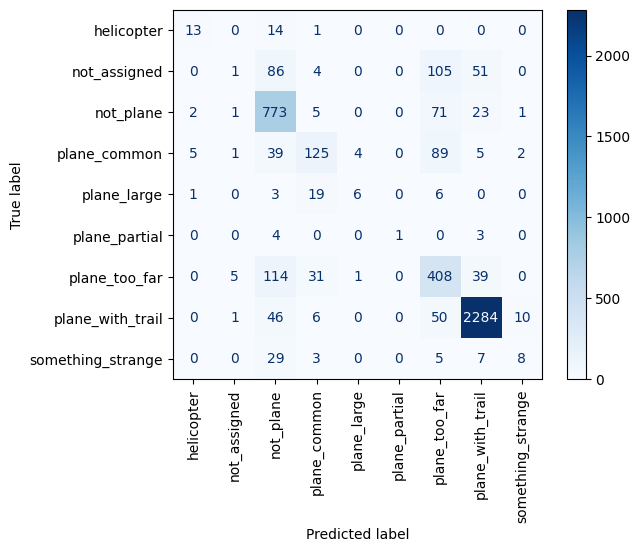

In [54]:
# Macierz pomyłek - wyświetlenie
ConfusionMatrixDisplay(cm_augmentation, display_labels=labels_inv).plot(cmap='Blues')
plt.tick_params(axis='x', rotation=90)
plt.show()

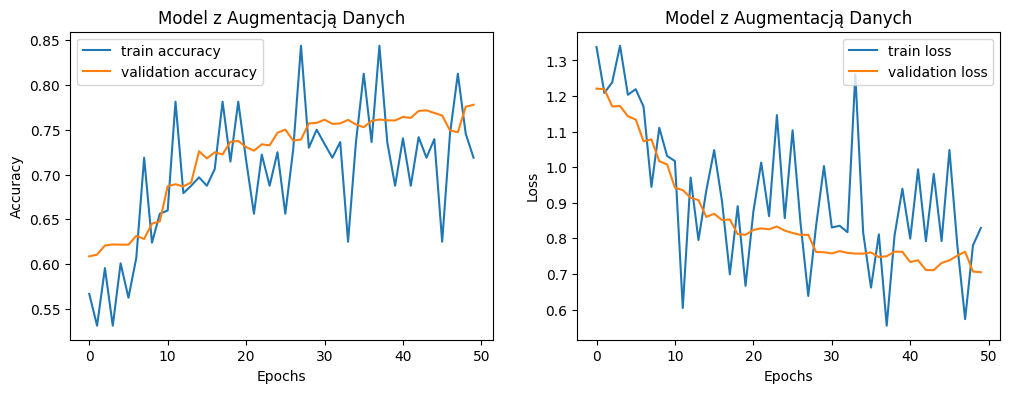

In [55]:
# Wyświetlenie krzywych uczenia dla modelu z augmentacją danych
plot_learning_curves(history_with_augmentation, 'Model z Augmentacją Danych')

Dodanie augmentacji nie poprawiło accuracy - wynosi ona obecnie 76%. Możliwe jednak, że dłuższy trening  pozwoliłby osiągnąć lepszy wynik.

# Podsumowanie 

W analizie przetestowano kilka podejść do treningu - brak balansu, balans klasowy z wykorzystaniem przypisania wag dla każdej z klas oraz augmentację danych z generatorem. Najmniej skuteczne okazło się podejście z augmentacją danych.
